In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"taban123456","key":"0e301cbc4b47db5ed837878cdfc1c469"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip utkface-new

Archive:  utkface-new.zip
replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import models ,layers, optimizers,losses
from  tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
from sklearn.model_selection import train_test_split
# import wandb
# from wandb.keras import WandbCallback
import seaborn as sn
import cv2

# Hyperparamete

In [9]:
epochs = 12
width = height = 224

In [10]:
images = []
ages = []


In [11]:
for image_name in os.listdir('/content/utkface_aligned_cropped/UTKFace')[0:9000]:
  parts = image_name.split('_')
  ages.append(int(parts[0]))
  image = cv2.imread(f'/content/utkface_aligned_cropped/UTKFace/{image_name}')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image )

In [12]:
images = pd.Series(images,name = 'Images')
ages = pd.Series(ages,name='Ages')
df = pd.concat([images,ages],axis=1)
df.head()


,Images,Ages
0,"[[[222, 205, 189], [220, 203, 187], [217, 198,...",54
1,"[[[130, 118, 122], [128, 116, 120], [127, 114,...",51
2,"[[[46, 44, 23], [46, 44, 23], [44, 42, 21], [4...",37
3,"[[[222, 202, 177], [212, 192, 167], [196, 179,...",85
4,"[[[200, 178, 167], [199, 177, 166], [191, 169,...",28


54


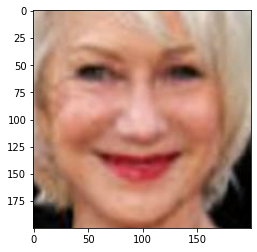

In [13]:
print(df['Ages'][0])
plt.imshow(df['Images'][0])

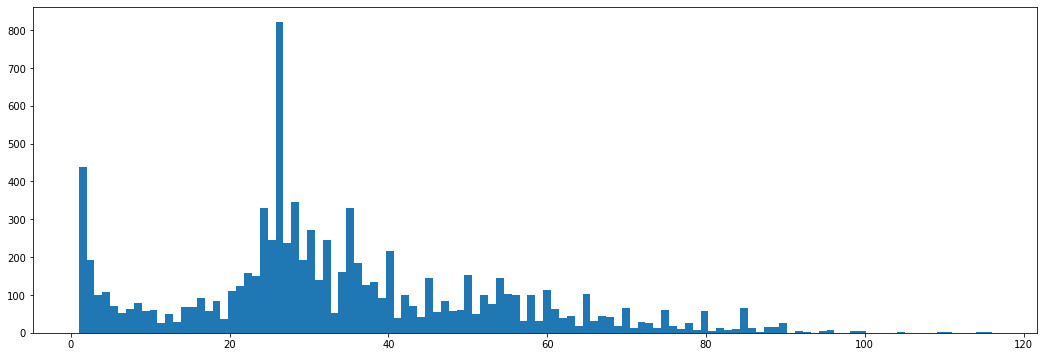

In [14]:
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=116)
plt.show()

In [19]:
under_30 = []
for i in range(len(df)):
  if 20<=df['Ages'].iloc[i]<=40:
    under_30.append(df.iloc[i])
under_30 = pd.DataFrame(under_30)
under_30 = under_30.sample(frac = 0.3)
uper_30 = df[df['Ages']>30]
df = pd.concat([under_30, uper_30])


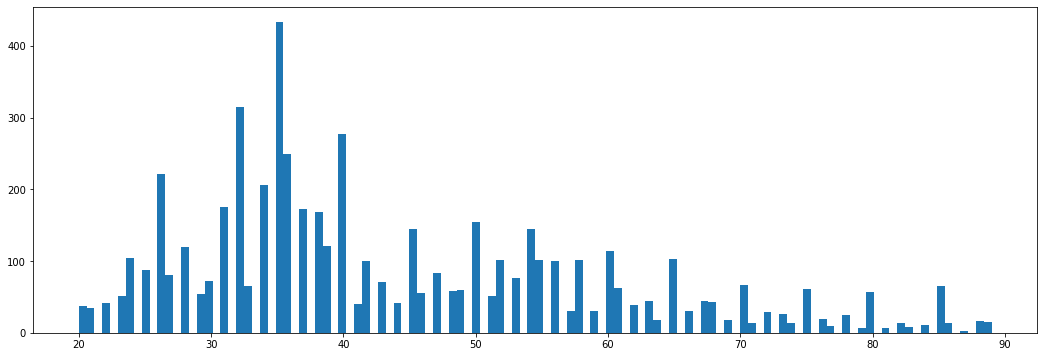

In [20]:
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=116)
plt.show()

In [21]:
df = df[df['Ages']<90]

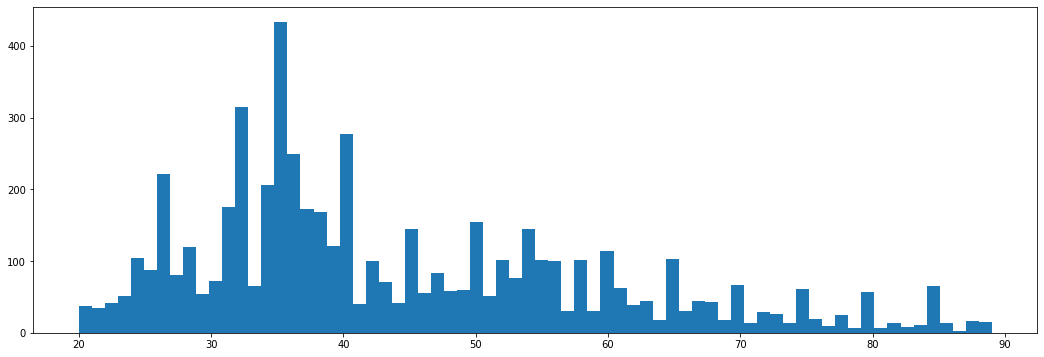

In [22]:
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=70)
plt.show()

In [23]:
X = []
Y = []
for i in range(len(df)):
  df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i],(width,height))
  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])
X = np.array(X)
Y = np.array(Y)  


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [24]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.2)

In [25]:
data_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True
)

In [26]:
train_data = data_generator.flow(x_train,
                                 y_train,
                                 batch_size = 32)

In [27]:
val_data = data_generator.flow(x_val,
                                 y_val,
                                 batch_size = 32)

In [28]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (width,height,3),
    weights = 'imagenet',
    include_top = False,
    pooling = 'avg'

)

In [29]:
for layer in base_model.layers[:-4]:
  layer_trainable = True

In [46]:
model =tf.keras.Sequential([
                            base_model,
                            
                            Dense(1,activation='relu')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                          loss= losses.MeanSquaredLogarithmicError())


In [47]:
model.fit(train_data,
          validation_data = val_data,
          epochs = 5,
          shuffle = True
          )

Epoch 1/5
141/141 [==============================] - 57s 371ms/step - loss: 0.5489 - val_loss: 0.8670
Epoch 2/5
141/141 [==============================] - 51s 362ms/step - loss: 0.0306 - val_loss: 2.4185
Epoch 3/5
141/141 [==============================] - 51s 364ms/step - loss: 0.0255 - val_loss: 0.1507
Epoch 4/5
141/141 [==============================] - 51s 364ms/step - loss: 0.0230 - val_loss: 0.1854
Epoch 5/5
141/141 [==============================] - 51s 365ms/step - loss: 0.0187 - val_loss: 0.2205


In [32]:
!pip install retina-face

In [48]:
import cv2
from retinaface import RetinaFace

the age is: [[20.461025]]


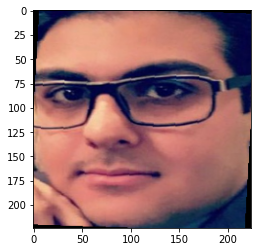

In [52]:
import matplotlib.pyplot as plt
def process_and_predict(image_path):

  faces = RetinaFace.extract_faces(img_path = image_path, align = True)
  image = faces[0]
  image = cv2.resize(image,(width,height))
  plt.imshow(image)
  image = image/255.0
  image = np.expand_dims(image, axis =0)
  result = model.predict(image)
  print('the age is:',result)
     
process_and_predict('4.jpg')